In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns


In [51]:
build_ener_df = pd.read_csv("2016_Building_Energy_Benchmarking.csv")

display(
    set(
        build_ener_df.loc[build_ener_df["PrimaryPropertyType"] == "Residence Hall"][
            "BuildingType"
        ].to_list()
    )
)
with pd.option_context("display.max_columns", None):
    display(
        build_ener_df.loc[
            (build_ener_df["PrimaryPropertyType"] == "Residence Hall")
            & (build_ener_df["BuildingType"] == "NonResidential")
        ]
    )
display(
    set(
        build_ener_df.loc[
            build_ener_df["LargestPropertyUseType"] == "Prison/Incarceration"
        ]["BuildingType"].to_list()
    )
)


{'Multifamily MR (5-9)', 'NonResidential'}

,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,PropertyName,Address,City,State,ZipCode,TaxParcelIdentificationNumber,CouncilDistrictCode,Neighborhood,Latitude,Longitude,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),ListOfAllPropertyUseTypes,LargestPropertyUseType,LargestPropertyUseTypeGFA,SecondLargestPropertyUseType,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseType,ThirdLargestPropertyUseTypeGFA,YearsENERGYSTARCertified,ENERGYSTARScore,SiteEUI(kBtu/sf),SiteEUIWN(kBtu/sf),SourceEUI(kBtu/sf),SourceEUIWN(kBtu/sf),SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),DefaultData,Comments,ComplianceStatus,Outlier,TotalGHGEmissions,GHGEmissionsIntensity
115,183,2016,NonResidential,Residence Hall,Emerson Hall,500 W. Emerson,Seattle,WA,98119.0,7443000375,7,MAGNOLIA / QUEEN ANNE,47.65068,-122.36331,2001,1.0,4,139600,37500,102100,Residence Hall/Dormitory,Residence Hall/Dormitory,135520.0,NaN,NaN,NaN,NaN,NaN,89.0,32.799999,35.400002,70.199997,74.699997,4.448582e+06,4.800620e+06,0.00,6.788682e+05,2316298.0,21322.839840,2132284.0,False,NaN,Compliant,NaN,129.39,0.93
186,294,2016,NonResidential,Residence Hall,Women's Residence at Seneca,1118 5th Avenue,Seattle,WA,98101.0,2301950000,7,DOWNTOWN,47.60790,-122.33266,1913,1.0,9,107572,0,107572,"Office, Residence Hall/Dormitory, Retail Store",Residence Hall/Dormitory,63934.0,Office,27143.0,Retail Store,10568.0,NaN,76.0,54.799999,57.799999,113.500000,117.099998,5.572503e+06,5.879083e+06,3076446.50,7.315522e+05,2496056.0,0.000000,0.0,False,NaN,Compliant,NaN,254.87,2.37
858,20029,2016,NonResidential,Residence Hall,Washington Phikeia Foundation,2111 NE 47th St,Seattle,WA,98105.0,0925049089,4,NORTHEAST,47.66282,-122.30500,1921,1.0,3,21499,0,21499,Residence Hall/Dormitory,Residence Hall/Dormitory,21499.0,NaN,NaN,NaN,NaN,NaN,85.0,28.100000,28.100000,88.400002,88.400002,6.051307e+05,6.051307e+05,0.00,1.773536e+05,605130.0,0.000000,0.0,False,NaN,Compliant,NaN,4.22,0.20
890,20160,2016,NonResidential,Residence Hall,Sigma Kappa Corp,4510 22nd Ave NE,Seattle,WA,98105.0,1321300090,4,NORTHEAST,47.66159,-122.30441,1930,1.0,3,20960,0,20960,Residence Hall/Dormitory,Residence Hall/Dormitory,20960.0,NaN,NaN,NaN,NaN,NaN,NaN,71.599998,79.500000,107.900002,117.599998,1.500310e+06,1.667310e+06,0.00,9.636570e+04,328800.0,11715.099610,1171510.0,False,NaN,Compliant,NaN,64.51,3.08
934,20273,2016,NonResidential,Residence Hall,Brooklyn Plaza,4106 Brooklyn Ave Ne,Seattle,WA,98105.0,1142001455,4,NORTHEAST,47.65711,-122.31409,1993,1.0,3,28572,0,28572,"Parking, Residence Hall/Dormitory",Residence Hall/Dormitory,22000.0,Parking,7000.0,NaN,NaN,NaN,16.0,123.500000,125.400002,242.500000,244.500000,2.717863e+06,2.759012e+06,0.00,3.479411e+05,1187175.0,15306.879880,1530688.0,False,NaN,Compliant,NaN,89.57,3.13
952,20323,2016,NonResidential,Residence Hall,Chancery Place Apartments,910 Marion Street,Seattle,WA,98104.0,1510600000,3,EAST,47.60817,-122.32654,1982,0.0,15,115775,31535,84240,"Office, Residence Hall/Dormitory",Residence Hall/Dormitory,150000.0,Office,25000.0,NaN,NaN,NaN,94.0,16.500000,17.400000,51.700001,54.599998,2.882490e+06,3.042217e+06,0.00,8.448093e+05,2882489.0,0.000000,0.0,False,NaN,Compliant,NaN,20.09,0.17
1104,20861,2016,NonResidential,Residence Hall,(ID20861) KEYSTONE GROUP HOME,3515 WOODLAND PARK AVE N,Seattle,WA,98103.0,1825049055,4,LAKE UNION,47.65014,-122.34424,1988,1.0,3,21118,0,21118,Residence Hall/Dormitory,Residence Hall/Dormitory,21118.0,NaN,NaN,NaN,NaN,NaN,49.0,64.500000,67.599998,138.100006,145.500000,1.361428e+06,1.427645e+06,0.00,2.083642e+05,710939.0,6504.889648,650489.0,False,NaN,Compliant,NaN,39.50,1.87
1210,21262,2016,NonResidential,Residence Hall,(ID21262) El Rey Apts,2119 2ND AVE,Seattle,WA,98121.0,1977200720,7,DOWNTOWN,47.61283,-122.34392,1909,1.0,4,29796,0,29796,Residence Hall/Dormitory,Residence Hall/Dormitory,29796.0,NaN,NaN,NaN,NaN,NaN,47.0,75.0000

{'Nonresidential COS'}

In [52]:
build_ener_df = pd.read_csv("2016_Building_Energy_Benchmarking.csv")

print(build_ener_df.shape[0])

build_ener_df = build_ener_df.loc[
    (
        ~build_ener_df["BuildingType"].isin(
            ["Multifamily HR (10+)", "Multifamily LR (1-4)", "Multifamily MR (5-9)"]
        )
    )
    & (
        ~build_ener_df["PrimaryPropertyType"].isin(
            [
                "High-Rise Multifamily",
                "Low-Rise Multifamily",
                "Mid-Rise Multifamily",
                "Residence Hall",
                # "Senior Care Community",
            ]
        )
    )
    & (
        ~build_ener_df["LargestPropertyUseType"].isin(
            [
                "Multifamily Housing",
                "Other - Lodging/Residential",
                "Residence Hall/Dormitory",
                # "Residential Care Facility",
                # "Senior Care Community",
            ]
        )
    )
]

build_ener_df.reset_index(drop=True, inplace=True)
print(build_ener_df.shape[0])


3376
1629


In [53]:
build_ener_df.describe()


,OSEBuildingID,DataYear,ZipCode,CouncilDistrictCode,Latitude,Longitude,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,...,SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),Comments,TotalGHGEmissions,GHGEmissionsIntensity
count,1629.000000,1629.0,1613.000000,1629.000000,1629.000000,1629.000000,1629.000000,1627.000000,1629.000000,1.629000e+03,...,1.627000e+03,1.626000e+03,1.627000e+03,1.627000e+03,1.627000e+03,1.627000e+03,1.627000e+03,0.0,1627.000000,1627.000000
mean,16106.317986,2016.0,98116.699318,4.353591,47.615659,-122.333159,1961.905463,1.171481,4.108042,1.195486e+05,...,8.546335e+06,8.159922e+06,5.217879e+05,1.735611e+06,5.921906e+06,1.988956e+04,1.988956e+06,NaN,187.193159,1.610621
std,13777.032930,0.0,17.999159,2.202625,0.048462,0.024682,32.525830,2.964442,6.572922,2.997562e+05,...,3.058713e+07,2.227995e+07,5.578664e+06,6.163686e+06,2.103050e+07,9.478920e+04,9.478920e+06,NaN,760.638229,2.358555
min,1.000000,2016.0,98006.000000,1.000000,47.499170,-122.411820,1900.000000,0.000000,0.000000,1.128500e+04,...,0.000000e+00,0.000000e+00,0.000000e+00,-3.382680e+04,-1.154170e+05,0.000000e+00,0.000000e+00,NaN,-0.800000,-0.020000
25%,577.000000,2016.0,98105.000000,2.000000,47.584540,-122.343400,1930.000000,1.000000,1.000000,2.961900e+04,...,1.222025e+06,1.287964e+06,0.000000e+00,2.118562e+05,7.228535e+05,0.000000e+00,0.000000e+00,NaN,19.840000,0.340000
50%,21117.000000,2016.0,98109.000000,4.000000,47.612200,-122.333050,1965.000000,1.000000,2.000000,4.976000e+04,...,2.559462e+06,2.691883e+06,0.000000e+00,4.744772e+05,1.618916e+06,4.910900e+03,4.910900e+05,NaN,49.290000,0.870000
75%,24560.000000,2016.0,98125.000000,7.000000,47.649040,-122.321930,1989.000000,1.000000,4.000000,1.060000e+05,...,6.979178e+06,7.239068e+06,0.000000e+00,1.436401e+06,4.901002e+06,1.517566e+04,1.517566e+06,NaN,144.600000,1.875000
max,50226.000000,2016.0,98199.000000,7.000000,47.733870,-122.258640,2015.000000,111.000000,99.000000,9.320156e+06,...,8.739237e+08,4.716139e+08,1.349435e+08,1.925775e+08,6.570744e+08,2.979090e+06,2.979090e+08,NaN,16870.980000,34.090000


In [54]:
for col in build_ener_df.columns:
    if (
        len(set(build_ener_df[col].to_list())) == 1
        or len(build_ener_df[col].loc[~build_ener_df[col].isna()].to_list()) == 0
    ):
        build_ener_df = build_ener_df.drop(labels=col, axis=1)

with pd.option_context("display.max_columns", None):
    display(build_ener_df)


,OSEBuildingID,BuildingType,PrimaryPropertyType,PropertyName,Address,ZipCode,TaxParcelIdentificationNumber,CouncilDistrictCode,Neighborhood,Latitude,Longitude,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),ListOfAllPropertyUseTypes,LargestPropertyUseType,LargestPropertyUseTypeGFA,SecondLargestPropertyUseType,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseType,ThirdLargestPropertyUseTypeGFA,YearsENERGYSTARCertified,ENERGYSTARScore,SiteEUI(kBtu/sf),SiteEUIWN(kBtu/sf),SourceEUI(kBtu/sf),SourceEUIWN(kBtu/sf),SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),DefaultData,ComplianceStatus,Outlier,TotalGHGEmissions,GHGEmissionsIntensity
0,1,NonResidential,Hotel,Mayflower park hotel,405 Olive way,98101.0,0659000030,7,DOWNTOWN,47.61220,-122.33799,1927,1.0,12,88434,0,88434,Hotel,Hotel,88434.0,NaN,NaN,NaN,NaN,NaN,60.0,81.699997,84.300003,182.500000,189.000000,7.226362e+06,7.456910e+06,2003882.00,1.156514e+06,3.946027e+06,12764.529300,1.276453e+06,False,Compliant,NaN,249.98,2.83
1,2,NonResidential,Hotel,Paramount Hotel,724 Pine street,98101.0,0659000220,7,DOWNTOWN,47.61317,-122.33393,1996,1.0,11,103566,15064,88502,"Hotel, Parking, Restaurant",Hotel,83880.0,Parking,15064.0,Restaurant,4622.0,NaN,61.0,94.800003,97.900002,176.100006,179.399994,8.387933e+06,8.664479e+06,0.00,9.504252e+05,3.242851e+06,51450.816410,5.145082e+06,False,Compliant,NaN,295.86,2.86
2,3,NonResidential,Hotel,5673-The Westin Seattle,1900 5th Avenue,98101.0,0659000475,7,DOWNTOWN,47.61393,-122.33810,1969,1.0,41,956110,196718,759392,Hotel,Hotel,756493.0,NaN,NaN,NaN,NaN,NaN,43.0,96.000000,97.699997,241.899994,244.100006,7.258702e+07,7.393711e+07,21566554.00,1.451544e+07,4.952666e+07,14938.000000,1.493800e+06,False,Compliant,NaN,2089.28,2.19
3,5,NonResidential,Hotel,HOTEL MAX,620 STEWART ST,98101.0,0659000640,7,DOWNTOWN,47.61412,-122.33664,1926,1.0,10,61320,0,61320,Hotel,Hotel,61320.0,NaN,NaN,NaN,NaN,NaN,56.0,110.800003,113.300003,216.199997,224.000000,6.794584e+06,6.946800e+06,2214446.25,8.115253e+05,2.768924e+06,18112.130860,1.811213e+06,False,Compliant,NaN,286.43,4.67
4,8,NonResidential,Hotel,WARWICK SEATTLE HOTEL (ID8),401 LENORA ST,98121.0,0659000970,7,DOWNTOWN,47.61375,-122.34047,1980,1.0,18,175580,62000,113580,"Hotel, Parking, Swimming Pool",Hotel,123445.0,Parking,68009.0,Swimming Pool,0.0,NaN,75.0,114.800003,118.699997,211.399994,215.600006,1.417261e+07,1.465650e+07,0.00,1.573449e+06,5.368607e+06,88039.984380,8.803998e+06,False,Compliant,NaN,505.01,2.88
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1624,50222,Nonresidential COS,Office,Horticulture building,1600 S Dakota St,NaN,1624049080,2,GREATER DUWAMISH,47.56722,-122.31154,1990,1.0,1,12294,0,12294,Office,Office,12294.0,NaN,NaN,NaN,NaN,NaN,46.0,69.099998,76.699997,161.699997,176.100006,8.497457e+05,9.430032e+05,0.00,1.536550e+05,5.242709e+05,3254.750244,3.254750e+05,True,Error - Correct Default Data,NaN,20.94,1.70
1625,50223,Nonresidential COS,Other,International district/Chinatown CC,719 8th Ave S,NaN,3558300000,2,DOWNTOWN,47.59625,-122.32283,2004,1.0,1,16000,0,16000,Other - Recreation,Other - Recreation,16000.0,NaN,NaN,NaN,NaN,NaN,NaN,59.400002,65.900002,114.199997,118.900002,9.502762e+05,1.053706e+06,0.00,1.162210e+05,3.965461e+05,5537.299805,5.537300e+05,False,Compliant,NaN,32.17,2.01
1626,50224,Nonresidential COS,Other,Queen Anne Pool,1920 1st Ave W,NaN,1794501150,7,MAGNOLIA / QUEEN ANNE,47.63644,-122.35784,1974,1.0,1,13157,0,13157,"Fitness Center/Health Club/Gym, Other - Recrea...",Other - Recreation,7583.0,Fitness Center/Health Club/Gym,5574.0,Swimming Pool,0.0,NaN,NaN,438.200012,460.100006,744.799988,767.799988,5.765898e+06,6.053764e+06,0.00,5.252517e+05,1.792159e+06,39737.390630,3.973739e+06,False,Compliant,NaN,223.54,16.99
1627,50225,Nonresident

In [55]:
discontin_feats = [
    "BuildingType",
    "PrimaryPropertyType",
    "PropertyName",
    "Address",
    "ZipCode",
    "TaxParcelIdentificationNumber",
    "CouncilDistrictCode",
    "Neighborhood",
    "Latitude",
    "Longitude",
    "YearBuilt",
    "ListOfAllPropertyUseTypes",
    "LargestPropertyUseType",
    "SecondLargestPropertyUseType",
    "ThirdLargestPropertyUseType",
    "DefaultData",
    "ComplianceStatus",
    "Outlier",
]
discontin_broad_feats = [
    "BuildingType",
    "PrimaryPropertyType",
    "ZipCode",
    "CouncilDistrictCode",
    "Neighborhood",
    "YearBuilt",
    "ListOfAllPropertyUseTypes",
    "LargestPropertyUseType",
    "SecondLargestPropertyUseType",
    "ThirdLargestPropertyUseType",
    "DefaultData",
    "ComplianceStatus",
    "Outlier",
]
unique_vals = {}

for feat in discontin_broad_feats:
    unique_vals[feat] = sorted([f"{i}" for i in set(build_ener_df[feat].to_numpy())])

display(unique_vals)


{'BuildingType': ['Campus',
  'NonResidential',
  'Nonresidential COS',
  'Nonresidential WA',
  'SPS-District K-12'],
 'PrimaryPropertyType': ['Distribution Center',
  'Hospital',
  'Hotel',
  'K-12 School',
  'Laboratory',
  'Large Office',
  'Medical Office',
  'Mixed Use Property',
  'Office',
  'Other',
  'Refrigerated Warehouse',
  'Restaurant',
  'Retail Store',
  'Self-Storage Facility',
  'Senior Care Community',
  'Small- and Mid-Sized Office',
  'Supermarket / Grocery Store',
  'University',
  'Warehouse',
  'Worship Facility'],
 'ZipCode': ['98006.0',
  '98011.0',
  '98013.0',
  '98020.0',
  '98033.0',
  '98053.0',
  '98070.0',
  '98101.0',
  '98102.0',
  '98103.0',
  '98104.0',
  '98105.0',
  '98106.0',
  '98107.0',
  '98108.0',
  '98109.0',
  '98111.0',
  '98112.0',
  '98113.0',
  '98114.0',
  '98115.0',
  '98116.0',
  '98117.0',
  '98118.0',
  '98119.0',
  '98121.0',
  '98122.0',
  '98124.0',
  '98125.0',
  '98126.0',
  '98133.0',
  '98134.0',
  '98136.0',
  '98144.0',
 

In [56]:
display(sorted(set(build_ener_df["Neighborhood"].to_list())))
build_ener_df["Neighborhood"] = build_ener_df["Neighborhood"].apply(lambda x: x.upper())
display(sorted(set(build_ener_df["Neighborhood"].to_list())))


['BALLARD',
 'Ballard',
 'CENTRAL',
 'Central',
 'DELRIDGE',
 'DELRIDGE NEIGHBORHOODS',
 'DOWNTOWN',
 'Delridge',
 'EAST',
 'GREATER DUWAMISH',
 'LAKE UNION',
 'MAGNOLIA / QUEEN ANNE',
 'NORTH',
 'NORTHEAST',
 'NORTHWEST',
 'North',
 'Northwest',
 'SOUTHEAST',
 'SOUTHWEST']

['BALLARD',
 'CENTRAL',
 'DELRIDGE',
 'DELRIDGE NEIGHBORHOODS',
 'DOWNTOWN',
 'EAST',
 'GREATER DUWAMISH',
 'LAKE UNION',
 'MAGNOLIA / QUEEN ANNE',
 'NORTH',
 'NORTHEAST',
 'NORTHWEST',
 'SOUTHEAST',
 'SOUTHWEST']

In [57]:
addresses = build_ener_df["Address"].to_list()
addr_cnts = {}

for addr in addresses:
    if addresses.count(addr) > 1:
        if addr not in addr_cnts:
            addr_cnts[addr] = addresses.count(addr)

for addr in addr_cnts.keys():
    lats_longs = []
    addr_df = build_ener_df.loc[build_ener_df["Address"] == addr]
    lats = addr_df["Latitude"].to_list()
    longs = addr_df["Longitude"].to_list()

    for i in range(len(lats)):
        lats_longs += [[lats[i], longs[i]]]

    lats_longs = list(set(tuple(sorted(sub)) for sub in lats_longs))
    addr_cnts[addr] = lats_longs

display(addr_cnts)

for addr in addr_cnts.keys():
    if len(addr_cnts[addr]) > 1:
        with pd.option_context("display.max_columns", None):
            display(build_ener_df.loc[build_ener_df["Address"] == addr])


{'500 5TH AVE': [(-122.32927, 47.6029), (-122.32842, 47.60378)],
 '2600 SW Barton St': [(-122.36627, 47.52254)],
 '3613 4th Ave S': [(-122.32811, 47.57199)],
 '1100 Olive Way': [(-122.33086, 47.61597)],
 '100 West Harrison': [(-122.3585, 47.62224)],
 '2203 Airport Way S': [(-122.32417, 47.5829)],
 '309 South Cloverdale Street': [(-122.33064, 47.52549)],
 '201 Thomas St.': [(-122.35251, 47.62082)],
 '2400 11th Ave East': [(-122.31644, 47.64132)],
 '14050 1st Ave NE': [(-122.32784, 47.73143)],
 '10510 5th Ave NE': [(-122.32232, 47.70541)],
 '4636 East Marginal Way South': [(-122.33872, 47.56121)],
 '2600 SW Holden St': [(-122.36624, 47.53419)],
 '2309 S Jackson St': [(-122.30189, 47.59881)]}

,OSEBuildingID,BuildingType,PrimaryPropertyType,PropertyName,Address,ZipCode,TaxParcelIdentificationNumber,CouncilDistrictCode,Neighborhood,Latitude,Longitude,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),ListOfAllPropertyUseTypes,LargestPropertyUseType,LargestPropertyUseTypeGFA,SecondLargestPropertyUseType,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseType,ThirdLargestPropertyUseTypeGFA,YearsENERGYSTARCertified,ENERGYSTARScore,SiteEUI(kBtu/sf),SiteEUIWN(kBtu/sf),SourceEUI(kBtu/sf),SourceEUIWN(kBtu/sf),SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),DefaultData,ComplianceStatus,Outlier,TotalGHGEmissions,GHGEmissionsIntensity
20,27,NonResidential,Other,King County Correctional Facility,500 5TH AVE,98104.0,0942001010,3,DOWNTOWN,47.60378,-122.32842,1985,1.0,19,385274,0,385274,Other,Other,385274.0,NaN,NaN,NaN,NaN,NaN,NaN,124.199997,128.600006,229.500000,232.899994,47859812.0,49539212.0,0.0,5351014.50,18257661.0,296021.5,29602150.0,False,Compliant,NaN,1699.45,4.41
568,779,NonResidential,Large Office,Administration Building,500 5TH AVE,98104.0,0942000920,7,DOWNTOWN,47.60290,-122.32927,1971,1.0,9,224857,0,224857,Office,Office,204993.0,NaN,NaN,NaN,NaN,NaN,79.0,74.500000,78.800003,195.699997,200.899994,15272491.0,16162013.0,4047481.0,3289861.75,11225008.0,0.0,0.0,False,Compliant,NaN,390.67,1.74


In [58]:
prop_use_types = build_ener_df["ListOfAllPropertyUseTypes"].to_list()
for i in range(len(prop_use_types)):
    prop_use_types[i] = str(prop_use_types[i]).split(", ")
    if prop_use_types[i] != sorted(prop_use_types[i]):
        print(prop_use_types[i])


['Other - Mall', 'Personal Services (Health/Beauty', 'Dry Cleaning', 'etc)']
['Repair Services (Vehicle', 'Shoe', 'Locksmith', 'etc)']
['Convenience Store without Gas Station', 'Data Center', 'Financial Office', 'Fitness Center/Health Club/Gym', 'Office', 'Other', 'Parking', 'Personal Services (Health/Beauty', 'Dry Cleaning', 'etc)', 'Restaurant']
['Office', 'Parking', 'Personal Services (Health/Beauty', 'Dry Cleaning', 'etc)']
['Fitness Center/Health Club/Gym', 'Office', 'Other - Education', 'Other - Recreation', 'Other - Restaurant/Bar', 'Outpatient Rehabilitation/Physical Therapy', 'Personal Services (Health/Beauty', 'Dry Cleaning', 'etc)', 'Restaurant', 'Retail Store', 'Self-Storage Facility', 'Vocat']
['Personal Services (Health/Beauty', 'Dry Cleaning', 'etc)', 'Retail Store', 'Supermarket/Grocery Store']
['Bar/Nightclub', 'Office', 'Personal Services (Health/Beauty', 'Dry Cleaning', 'etc)']
['Data Center', 'Non-Refrigerated Warehouse', 'Other', 'Refrigerated Warehouse', 'Repair S

In [59]:
print(build_ener_df.shape[0])

build_ener_df_def_dat = build_ener_df.loc[build_ener_df["DefaultData"]]
build_ener_df_comp_err = build_ener_df.loc[
    build_ener_df["ComplianceStatus"] == "Error - Correct Default Data"
]

if build_ener_df_def_dat.compare(build_ener_df_comp_err).shape[0] == 0:
    build_ener_df = build_ener_df.loc[
        ~(build_ener_df["ComplianceStatus"] == "Error - Correct Default Data")
    ]

    build_ener_df.reset_index(drop=True, inplace=True)

print(build_ener_df.shape[0])


1629
1541


In [64]:
# PropertyGFATotal
# SiteEUI(kBtu/sf)
# SiteEnergyUse(kBtu)
display(
    pd.DataFrame(
        {
            "SiteEnergyUse(kBtu)": build_ener_df["SiteEnergyUse(kBtu)"],
            "SiteEnergyUse(kBtu)Reconst": build_ener_df["PropertyGFATotal"]
            * build_ener_df["SiteEUI(kBtu/sf)"],
        }
    ).head(20)
)
display(
    pd.DataFrame(
        {
            "SiteEnergyUse(kBtu)": build_ener_df["SiteEnergyUse(kBtu)"],
            "SiteEnergyUse(kBtu)Reconst": build_ener_df["PropertyGFABuilding(s)"]
            * build_ener_df["SiteEUI(kBtu/sf)"],
        }
    ).head(20)
)


,SiteEnergyUse(kBtu),SiteEnergyUse(kBtu)Reconst
0,7226362.5,7.225058e+06
1,8387933.0,9.818057e+06
2,72587024.0,9.178656e+07
3,6794584.0,6.794256e+06
4,14172606.0,2.015658e+07
5,12086616.0,1.324090e+07
6,5758795.0,5.876967e+06
7,6298131.5,6.299249e+06
8,13723820.0,1.372546e+07
9,16016644.0,1.831829e+07


,SiteEnergyUse(kBtu),SiteEnergyUse(kBtu)Reconst
0,7226362.5,7.225058e+06
1,8387933.0,8.389990e+06
2,72587024.0,7.290163e+07
3,6794584.0,6.794256e+06
4,14172606.0,1.303898e+07
5,12086616.0,8.178249e+06
6,5758795.0,5.876967e+06
7,6298131.5,6.299249e+06
8,13723820.0,1.372546e+07
9,16016644.0,1.601253e+07


In [ ]:
redund_feats = ["PropertyName", "Address", "TaxParcelIdentificationNumber", "Electricity(kWh)", "NaturalGas(therms)", "DefaultData"]
compos_feats = []
non_normalizable_feats = ["ListOfAllPropertyUseTypes"]

In [30]:
redund_id = ["PropertyName", "Address", "TaxParcelIdentificationNumber"]
all_categs = [
    "BuildingType",
    "PrimaryPropertyType",
    "CouncilDistrictCode",
    "Neighborhood",
    "YearBuilt",
    "ListOfAllPropertyUseTypes",
    "LargestPropertyUseType",
    "SecondLargestPropertyUseType",
    "ThirdLargestPropertyUseType",
    "ComplianceStatus",
    "Outlier",
]
locat_contin = []
locat_categ = []
categs_to_check = []


{'DataYear': ['2016'],
 'BuildingType': ['Campus',
  'NonResidential',
  'Nonresidential COS',
  'Nonresidential WA',
  'SPS-District K-12'],
 'PrimaryPropertyType': ['Distribution Center',
  'Hospital',
  'Hotel',
  'K-12 School',
  'Laboratory',
  'Large Office',
  'Medical Office',
  'Mixed Use Property',
  'Office',
  'Other',
  'Refrigerated Warehouse',
  'Restaurant',
  'Retail Store',
  'Self-Storage Facility',
  'Small- and Mid-Sized Office',
  'Supermarket / Grocery Store',
  'University',
  'Warehouse',
  'Worship Facility'],
 'City': ['Seattle'],
 'State': ['WA'],
 'CouncilDistrictCode': ['1', '2', '3', '4', '5', '6', '7'],
 'Neighborhood': ['BALLARD',
  'Ballard',
  'CENTRAL',
  'Central',
  'DELRIDGE',
  'DELRIDGE NEIGHBORHOODS',
  'DOWNTOWN',
  'Delridge',
  'EAST',
  'GREATER DUWAMISH',
  'LAKE UNION',
  'MAGNOLIA / QUEEN ANNE',
  'NORTH',
  'NORTHEAST',
  'NORTHWEST',
  'North',
  'Northwest',
  'SOUTHEAST',
  'SOUTHWEST'],
 'LargestPropertyUseType': ['Adult Education',

['DataYear', 'City', 'State']


,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,PropertyName,Address,City,State,ZipCode,TaxParcelIdentificationNumber,CouncilDistrictCode,Neighborhood,Latitude,Longitude,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),ListOfAllPropertyUseTypes,LargestPropertyUseType,LargestPropertyUseTypeGFA,SecondLargestPropertyUseType,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseType,ThirdLargestPropertyUseTypeGFA,YearsENERGYSTARCertified,ENERGYSTARScore,SiteEUI(kBtu/sf),SiteEUIWN(kBtu/sf),SourceEUI(kBtu/sf),SourceEUIWN(kBtu/sf),SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),DefaultData,Comments,ComplianceStatus,Outlier,TotalGHGEmissions,GHGEmissionsIntensity
22,28,2016,SPS-District K-12,K-12 School,Graham Hill Elementary,5149 S. Graham St.,Seattle,WA,98118.0,1102000138,2,SOUTHEAST,47.54576,-122.26853,1961,1.0,2,56228,0,56228,K-12 School,K-12 School,58916.0,NaN,NaN,NaN,NaN,NaN,95.0,26.100000,29.100000,60.700001,64.599998,1.539478e+06,1.713624e+06,0.0,274605.90630,9.369550e+05,6025.229004,6.025230e+05,True,NaN,Error - Correct Default Data,NaN,38.53,0.69
30,36,2016,SPS-District K-12,K-12 School,Jane Addams Middle,11051 34th Ave. N.E.,Seattle,WA,98125.0,0752000170,5,NORTH,47.70994,-122.29301,1949,1.0,2,160645,0,160645,K-12 School,K-12 School,164229.0,NaN,NaN,NaN,NaN,NaN,75.0,41.299999,47.500000,68.099998,75.699997,6.779173e+06,7.800350e+06,0.0,570809.18750,1.947601e+06,48315.718750,4.831572e+06,True,NaN,Error - Correct Default Data,NaN,270.18,1.68
38,51,2016,SPS-District K-12,K-12 School,Eckstein Middle,3003 N.E. 75th St.,Seattle,WA,98115.0,0425049022,4,NORTHEAST,47.68252,-122.29498,1950,1.0,2,175565,0,175565,K-12 School,K-12 School,182861.0,NaN,NaN,NaN,NaN,NaN,88.0,35.000000,40.099998,55.000000,60.400002,6.399128e+06,7.329818e+06,0.0,468840.50000,1.599684e+06,47994.433590,4.799443e+06,True,NaN,Error - Correct Default Data,NaN,266.05,1.52
86,125,2016,SPS-District K-12,K-12 School,Mercer International Middle,1600 Columbian Way S.,Seattle,WA,98108.0,1624049214,2,GREATER DUWAMISH,47.56413,-122.31208,1957,1.0,1,130862,0,130862,K-12 School,K-12 School,134446.0,NaN,NaN,NaN,NaN,NaN,61.0,48.000000,54.299999,85.599998,93.500000,6.456026e+06,7.300978e+06,0.0,663194.50000,2.262820e+06,41932.066410,4.193207e+06,True,NaN,Error - Correct Default Data,NaN,238.48,1.82
87,127,2016,SPS-District K-12,K-12 School,Orca K-8 School,5215 46th Ave. S.,Seattle,WA,98118.0,1704900242,2,SOUTHEAST,47.55478,-122.27596,1989,1.0,3,59955,0,59955,K-12 School,K-12 School,59955.0,NaN,NaN,NaN,NaN,NaN,93.0,27.200001,29.200001,78.699997,83.000000,1.633399e+06,1.749171e+06,0.0,420989.40630,1.436416e+06,1969.832520,1.969830e+05,True,NaN,Error - Correct Default Data,NaN,20.48,0.34
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3036,27955,2016,SPS-District K-12,K-12 School,Montlake Elementary,2409 22nd Ave. E.,Seattle,WA,98112.0,6788200735,3,EAST,47.64063,-122.30428,1925,1.0,2,27273,0,27273,K-12 School,K-12 School,27273.0,NaN,NaN,NaN,NaN,NaN,90.0,46.099998,52.700001,81.900002,90.900002,1.258619e+06,1.436271e+06,0.0,127941.00000,4.365350e+05,8220.842773,8.220840e+05,True,NaN,Error - Correct Default Data,NaN,46.70,1.71
3126,39332,2016,SPS-District K-12,K-12 School,South Shore K-8,4800 S. Henderson,Seattle,WA,98118.0,2123700250,2,SOUTHEAST,47.52374,-122.27201,2009,1.0,2,138705,0,138705,K-12 School,K-12 School,138705.0,NaN,NaN,NaN,NaN,NaN,84.0,35.799999,38.500000,82.800003,85.699997,4.959298e+06,5.344758e+06,0.0,880538.00000,3.004396e+06,19549.021480,1.954902e+06,True,NaN,Error - Correct Default Data,NaN,124.77,0.90
3366,50210,2016,Nonresidential COS,Office,Central West HQ / Brown Bear,1403 w howe,Seattle,WA,NaN,2425039137,7,MAGNOLIA / QUEEN ANNE,47.63572,-122.37525,1952,1.0,1,13661,0,13661,Office,Offi

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1605 entries, 0 to 3375
Data columns (total 46 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   OSEBuildingID                    1605 non-null   int64  
 1   DataYear                         1605 non-null   int64  
 2   BuildingType                     1605 non-null   object 
 3   PrimaryPropertyType              1605 non-null   object 
 4   PropertyName                     1605 non-null   object 
 5   Address                          1605 non-null   object 
 6   City                             1605 non-null   object 
 7   State                            1605 non-null   object 
 8   ZipCode                          1592 non-null   float64
 9   TaxParcelIdentificationNumber    1605 non-null   object 
 10  CouncilDistrictCode              1605 non-null   int64  
 11  Neighborhood                     1605 non-null   object 
 12  Latitude            

{'500 5TH AVE': 2,
 '2600 SW Barton St': 4,
 '3613 4th Ave S': 2,
 '1100 Olive Way': 2,
 '100 West Harrison': 2,
 '2203 Airport Way S': 4,
 '309 South Cloverdale Street': 4,
 '201 Thomas St.': 2,
 '2400 11th Ave East': 2,
 '14050 1st Ave NE': 2,
 '10510 5th Ave NE': 2,
 '4636 East Marginal Way South': 2,
 '2600 SW Holden St': 2,
 '2309 S Jackson St': 2}

In [16]:
with pd.option_context("display.max_columns", None):
    display(
        build_ener_df.loc[build_ener_df["Address"] == "309 South Cloverdale Street"]
    )


,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,PropertyName,Address,City,State,ZipCode,TaxParcelIdentificationNumber,CouncilDistrictCode,Neighborhood,Latitude,Longitude,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),ListOfAllPropertyUseTypes,LargestPropertyUseType,LargestPropertyUseTypeGFA,SecondLargestPropertyUseType,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseType,ThirdLargestPropertyUseTypeGFA,YearsENERGYSTARCertified,ENERGYSTARScore,SiteEUI(kBtu/sf),SiteEUIWN(kBtu/sf),SourceEUI(kBtu/sf),SourceEUIWN(kBtu/sf),SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),DefaultData,Comments,ComplianceStatus,Outlier,TotalGHGEmissions,GHGEmissionsIntensity
597,799,2016,NonResidential,Distribution Center,Cloverdale Business Park Building D,309 South Cloverdale Street,Seattle,WA,98108.0,3224049012,1,GREATER DUWAMISH,47.52549,-122.33064,1979,1.0,1,54880,0,54880,Distribution Center,Distribution Center,55000.0,NaN,NaN,NaN,NaN,NaN,32.0,50.200001,54.799999,99.900002,104.699997,2763597.00,3013861.500,0.0,363654.1875,1240788.0,15228.089840,1522809.0,False,NaN,Compliant,NaN,89.53,1.63
2123,24537,2016,NonResidential,Warehouse,Cloverdale Business Park Building B,309 South Cloverdale Street,Seattle,WA,98108.0,3224049012,1,GREATER DUWAMISH,47.52549,-122.33064,1979,1.0,1,33320,0,33320,"Non-Refrigerated Warehouse, Office",Non-Refrigerated Warehouse,32200.0,Office,1200.0,NaN,NaN,NaN,NaN,70.000000,74.800003,154.199997,159.300003,2339234.00,2499644.750,0.0,377852.5938,1289233.0,10500.010740,1050001.0,False,NaN,Compliant,NaN,64.75,1.94
2124,24538,2016,NonResidential,Warehouse,Cloverdale Business Park Building C,309 South Cloverdale Street,Seattle,WA,98108.0,3224049012,1,GREATER DUWAMISH,47.52549,-122.33064,1979,1.0,1,48020,0,48020,Non-Refrigerated Warehouse,Non-Refrigerated Warehouse,47800.0,NaN,NaN,NaN,NaN,NaN,71.0,49.700001,53.700001,115.599998,119.800003,2373568.25,2567827.750,0.0,425119.5938,1450508.0,9230.599609,923060.0,False,NaN,Compliant,NaN,59.14,1.23
2125,24539,2016,NonResidential,Warehouse,Cloverdale Business Park Building E,309 South Cloverdale Street,Seattle,WA,98108.0,3224049012,1,GREATER DUWAMISH,47.52549,-122.33064,1979,1.0,1,27420,0,27420,Non-Refrigerated Warehouse,Non-Refrigerated Warehouse,27850.0,NaN,NaN,NaN,NaN,NaN,55.0,42.200001,48.099998,82.500000,88.599998,1176342.25,1340563.125,0.0,148811.0000,507743.0,6685.990234,668599.0,False,NaN,Compliant,NaN,39.05,1.42


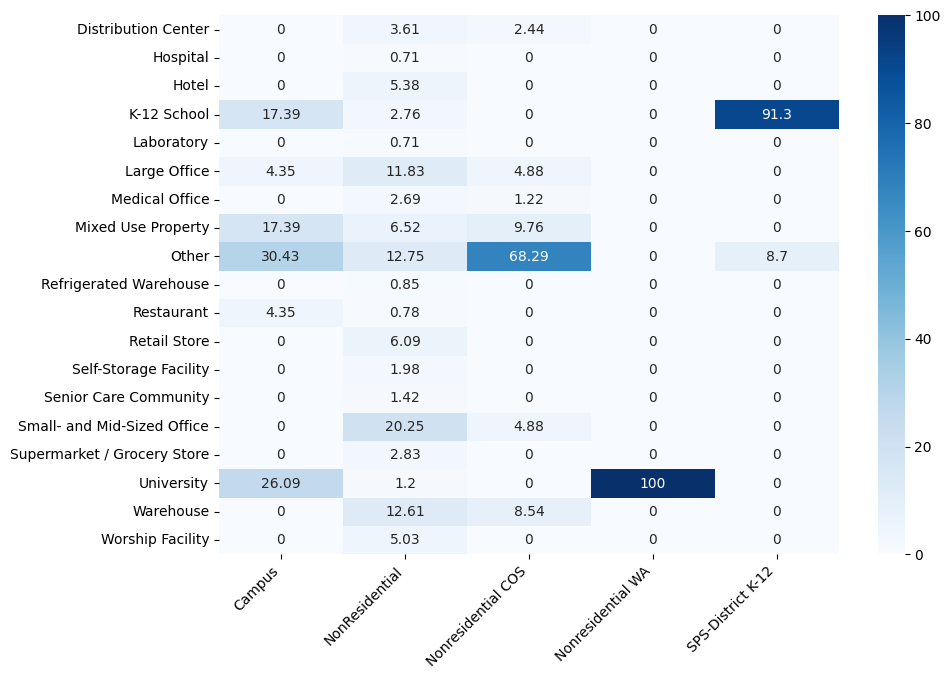

In [60]:
build_types = sorted([f"{i}" for i in set(build_ener_df["BuildingType"].to_numpy())])
prop_types = sorted(
    [f"{i}" for i in set(build_ener_df["PrimaryPropertyType"].to_numpy())]
)
build_and_prop = {}

for build_type in build_types:
    prop_type_vals = {}
    build_type_total = prop_type_total = len(
        build_ener_df[build_ener_df["BuildingType"] == build_type]
    )

    for prop_type in prop_types:
        prop_type_vals[prop_type] = round(
            100
            * (
                len(
                    build_ener_df[
                        (build_ener_df["PrimaryPropertyType"] == prop_type)
                        & (build_ener_df["BuildingType"] == build_type)
                    ]
                )
                / build_type_total
            ),
            2,
        )

    build_and_prop[build_type] = prop_type_vals

fig, ax = plt.subplots(figsize=(10, 7))
sns.heatmap(
    data=pd.DataFrame(build_and_prop),
    cmap=sns.color_palette("Blues", as_cmap=True),
    annot=True,
    fmt="g",
    ax=ax,
)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment="right")
plt.show()


In [ ]:
build_ener_df.loc[build_ener_df["BuildingType"] == "Nonresidential WA"]


,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,PropertyName,Address,City,State,ZipCode,TaxParcelIdentificationNumber,...,Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),DefaultData,Comments,ComplianceStatus,Outlier,TotalGHGEmissions,GHGEmissionsIntensity
3359,50101,2016,Nonresidential WA,University,Burke Museum,4331 Memorial Way NE,Seattle,WA,98195.0,1625049001,...,932244.6875,3180819.0,0.0,0.0,False,NaN,Compliant,NaN,22.17,0.33


* Numeric encoding on all categorical

* LargestPropertyUseType
    * SiteEUI [high is bad](0 to highest -> 0 to 100)
    * GHGEmissionsIntensity [high is bad](0 to highest -> 0 to 100)
    * ENERGYSTARScore [high is good](reversed -> 0 to 100)

    * PropertyGFATotal
        * SiteEnergyUse
        * TotalGHGEmissions

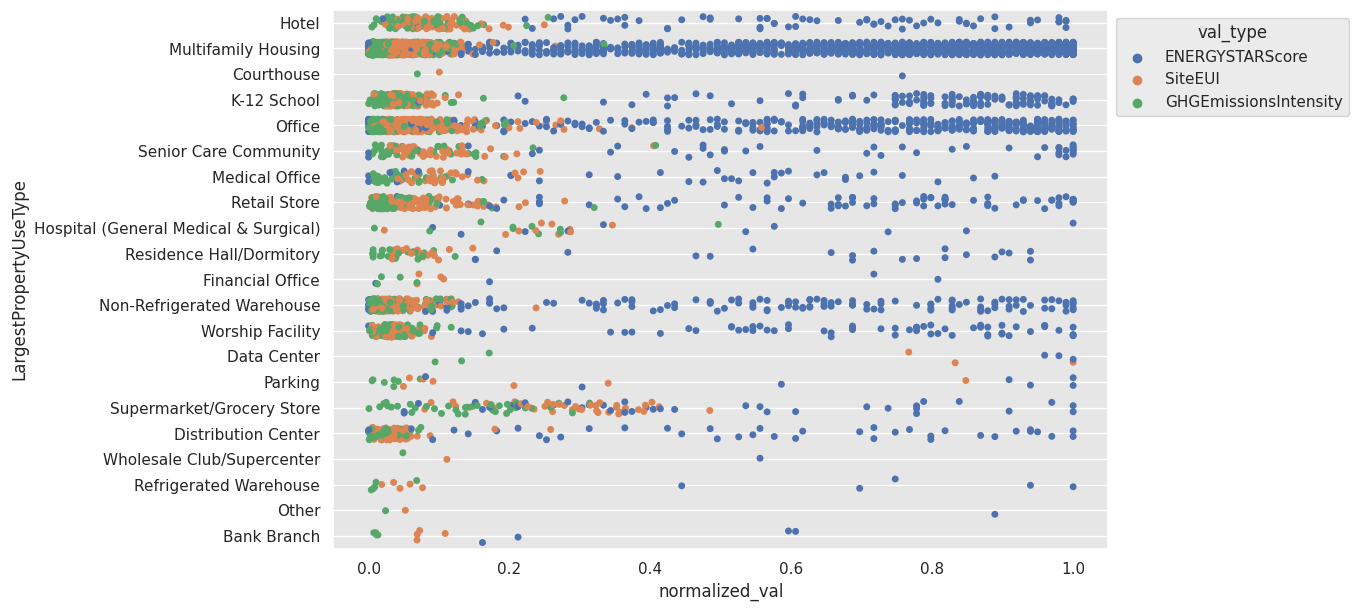

In [ ]:
# print(
#     '"LargestPropertyUseType" unique entries:\n\t'
#     + "\n\t".join(sorted([f"{i}" for i in set(build_ener_df["LargestPropertyUseType"].to_numpy())]))
# )

prop_use_df = build_ener_df[
    [
        "LargestPropertyUseType",
        "ENERGYSTARScore",
        "SiteEUI(kBtu/sf)",
        "GHGEmissionsIntensity",
    ]
]
prop_use_df = prop_use_df.rename(columns={"SiteEUI(kBtu/sf)": "SiteEUI"})
prop_use_df = prop_use_df.dropna()

prop_use_df.reset_index(drop=True, inplace=True)

min_max_scaler = lambda x: (x - x.min()) / (x.max() - x.min())

for col in ["ENERGYSTARScore", "SiteEUI", "GHGEmissionsIntensity"]:
    prop_use_df[col] = min_max_scaler(prop_use_df[col])


def to_normal_vals(row):
    new_rows = {"LargestPropertyUseType": [], "normalized_val": [], "val_type": []}

    for col in ["ENERGYSTARScore", "SiteEUI", "GHGEmissionsIntensity"]:
        new_rows["LargestPropertyUseType"] += [row["LargestPropertyUseType"]]
        new_rows["normalized_val"] += [row[col]]
        new_rows["val_type"] += [col]

    return pd.DataFrame(new_rows)


prop_use_df = pd.concat(
    prop_use_df.apply(to_normal_vals, axis=1).to_list(), ignore_index=True
)

fig, ax = plt.subplots(figsize=(10, 7))
sns.stripplot(
    data=prop_use_df,
    x="normalized_val",
    y="LargestPropertyUseType",
    # kind="scatter",
    hue="val_type",
    jitter=0.25,
    ax=ax,
)
# sns.set(rc={"figure.figsize": (15, 8)})
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.grid()
plt.show()

# siteeui_max = prop_use_df["SiteEUI"].max()
# enerstar_at_siteeui_max = prop_use_df.loc[prop_use_df["SiteEUI"] == siteeui_max]
# enerstar_at_siteeui_max
# ghgei_max = prop_use_df["GHGEmissionsIntensity"].max()
# with pd.option_context("mode.chained_assignment", None):
#     prop_use_df["ENERGYSTARScore"] = prop_use_df["ENERGYSTARScore"].apply(lambda x: 100 - x)
#     prop_use_df["SiteEUI"] = prop_use_df["SiteEUI"].apply(lambda x:  x * 100 / siteeui_max)
#     prop_use_df["GHGEmissionsIntensity"] = prop_use_df["GHGEmissionsIntensity"].apply(lambda x:  x * 100 / ghgei_max)
# prop_use_df
